# Delhivery-Feature Engeneering
 **Objective**
* Clean, sanitize and manipulate data to get useful features out of raw fields
* Make scence of the raw data and extract features to build forecasting models

***Column Profiling:***
1. **data** - tells whether the data is testing or training data                         
2. **trip_creation_time** – Timestamp of trip creation
3. **route_schedule_uuid** – Unique Id for a particular route schedule
4. **route_type** – Transportation type
5. **trip_uuid** - Unique ID given to a particular trip   (A trip may include different source and destination centers)                
6. **source_center** - Source ID of trip origin                 
7. **source_name** - Source Name of trip origin                    
8. **destination_cente** – Destination ID         
9. **destination_name** – Destination Name              
10. **od_start_time** – Trip start time                
11. **od_end_time** –  Trip end time                                
12. **start_scan_to_end_scan** – Time taken to deliver from source to destination    
13. **is_cutoff** – Unknown field                   
14. **cutoff_factor**  – Unknown field                       
15. **cutoff_timestamp** –  Unknown field             
16. **actual_distance_to_destination** – Distance in Kms between source and destination warehouse
17. **actual_time** –  Actual time taken to complete the delivery (Cumulative)
18. **osrm_time** – An open-source routing engine time calculator which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) and gives the time (Cumulative)
19. **osrm_distance** – An open-source routing engine which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) (Cumulative)
20. **factor**  –  Unknown field                 
21. **segment_actual_time** – This is a segment time. Time taken by the subset of the package delivery
22. **segment_osrm_time** –  This is the OSRM segment time. Time taken by the subset of the package delivery      
23. **segment_osrm_distance** –   This is the OSRM distance. Distance covered by subset of the package delivery       
24. **segment_factor** – Unknown field


##  1. Basic data cleaning and exploration

### a. Handle missing values in the data

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scipy.stats import  levene, ttest_ind

In [ ]:

# Data address
url = 'https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181'
# load data
raw_data = pd.read_csv(url)


In [ ]:
# exploring data
print(f'# of rows{raw_data.shape[0]}')
print("--------------------------------------------------")
print(f'# of columns: {len(raw_data.columns)}')
print("--------------------------------------------------")
print(f'# of duplicate columns: {raw_data.duplicated().sum()}')
print("--------------------------------------------------")

# of rows144867
--------------------------------------------------
# of columns: 24
--------------------------------------------------
# of duplicate columns: 0
--------------------------------------------------


In [ ]:
# information about column data types, missing values etc.
print("----------------------------------------------------")
print(raw_data.isnull().sum(axis=0))
print('----------------------------------------------------')

----------------------------------------------------
data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
is_cutoff                           0
cutoff_factor                       0
cutoff_timestamp                    0
actual_distance_to_destination      0
actual_time                         0
osrm_time                           0
osrm_distance                       0
factor                              0
segment_actual_time                 0
segment_osrm_time                   0
segment_osrm_distance               0
segment_factor                      0
dtype: int64
----------------------

- No information is given about the following columns, so we simply ignore these features from the data
- data column is not required
- we delete the following colums from the raw_data : ['data','is_cutoff','cutoff_factor','cutoff_timestamp','factor','segment_factor']


In [ ]:
# drop the columns with no information
raw_reduced_data = raw_data.drop(columns=['data','is_cutoff','cutoff_factor','cutoff_timestamp','factor','segment_factor'],axis=0)

- There are 293 null values in the  source_name column and 231 null values in destination_name column.
Since the missing value number is small compared to the available data points(144,867) we can delete the missing value rows

In [ ]:
raw_reduced_data.dropna(inplace=True)

### b. Analyze structure of the data

In [ ]:
print("There are {} rows and {} columns".format(raw_reduced_data.shape[0],raw_reduced_data.shape[1]))


There are 144316 rows and 18 columns


In [ ]:
raw_reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144316 entries, 0 to 144866
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_creation_time              144316 non-null  object 
 1   route_schedule_uuid             144316 non-null  object 
 2   route_type                      144316 non-null  object 
 3   trip_uuid                       144316 non-null  object 
 4   source_center                   144316 non-null  object 
 5   source_name                     144316 non-null  object 
 6   destination_center              144316 non-null  object 
 7   destination_name                144316 non-null  object 
 8   od_start_time                   144316 non-null  object 
 9   od_end_time                     144316 non-null  object 
 10  start_scan_to_end_scan          144316 non-null  float64
 11  actual_distance_to_destination  144316 non-null  float64
 12  actual_time     

In [ ]:
# convert dtype of datatime types
date_time_cols = ['trip_creation_time', 'od_start_time','od_end_time']
for col in date_time_cols:
    raw_reduced_data[col] = pd.to_datetime(raw_reduced_data[col])

### c. Merging the rows using trip_uuid

In [ ]:
merged_data = raw_reduced_data.groupby(['trip_uuid']).agg(
    trip_creation_time = ("trip_creation_time", "first"),
    route_type = ("route_type", "first"),
    source_name = ("source_name", "first"),
    destination_name = ("destination_name", "last"),
    od_start_time = ("od_start_time", "first"),
    od_end_time = ("od_end_time", "last"),
    start_scan_to_end_scan = ("start_scan_to_end_scan", "sum"),
    actual_distance_to_destination = ("actual_distance_to_destination", "sum"),  # total of both rows
    actual_time = ("actual_time", "sum"),
    osrm_time = ("osrm_time", "sum"),
    osrm_distance = ("osrm_distance", "sum"),
    total_segment_actual_time = ("segment_actual_time", "sum"),
    total_segment_osrm_time = ("segment_osrm_time", "sum"),
    total_segment_osrm_distance = ("segment_osrm_distance", "sum")
)


In [ ]:
merged_data.head()

,trip_creation_time,route_type,source_name,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,total_segment_actual_time,total_segment_osrm_time,total_segment_osrm_distance
trip_uuid,,,,,,,,,,,,,,
trip-153671041653548748,2018-09-12 00:00:16.535741,FTL,Bhopal_Trnsport_H (Madhya Pradesh),Gurgaon_Bilaspur_HB (Haryana),2018-09-12 00:00:16.535741,2018-09-13 13:40:23.123744,43659.0,8860.812105,15682.0,7787.0,10577.7647,1548.0,1008.0,1320.4733
trip-153671042288605164,2018-09-12 00:00:22.886430,Carting,Tumkur_Veersagr_I (Karnataka),Chikblapur_ShntiSgr_D (Karnataka),2018-09-12 00:00:22.886430,2018-09-12 03:01:59.598855,906.0,240.208306,399.0,210.0,269.4308,141.0,65.0,84.1894
trip-153671043369099517,2018-09-12 00:00:33.691250,FTL,Bangalore_Nelmngla_H (Karnataka),Chandigarh_Mehmdpur_H (Punjab),2018-09-12 00:00:33.691250,2018-09-14 17:34:55.442454,248631.0,68163.502238,112225.0,65768.0,89447.2488,3308.0,1941.0,2545.2678
trip-153671046011330457,2018-09-12 00:01:00.113710,Carting,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),2018-09-12 00:01:00.113710,2018-09-12 01:41:29.809822,200.0,28.529648,82.0,24.0,31.6475,59.0,16.0,19.8766
trip-153671052974046625,2018-09-12 00:02:09.740725,FTL,Bellary_Dc (Karnataka),Bellary_Dc (Karnataka),2018-09-12 00:02:09.740725,2018-09-12 12:00:30.683231,1586.0,239.007304,556.0,207.0,266.2914,340.0,115.0,146.7919


## 2. Build some features to prepare the data for actual analysis.


### a.extract features out of source_name: City-place-code (State)

In [ ]:

merged_data['source_name_city'] = merged_data.source_name.str.extract(r'([A-Za-z]+)_',expand = True)
merged_data['source_name_place'] = merged_data.source_name.str.extract(r'_([A-Za-z]+)_',expand = True)
merged_data['source_name_state'] = merged_data.source_name.str.extract(r'\(([A-Za-z ]+)\)',expand = True)

### b.extract features out of destination_name: City-place-code (State)

In [ ]:
merged_data['destination_city'] = merged_data.destination_name.str.extract(r'([A-Za-z]+)_',expand = True)
merged_data['destination_place'] = merged_data.destination_name.str.extract(r'_([A-Za-z]+)_',expand = True)
merged_data['destination_state'] = merged_data.destination_name.str.extract(r'\(([A-Za-z ]+)\)',expand = True)

### c. Extracting features from trip_creation_time

In [ ]:
merged_data['trip_creation_year'] = merged_data['trip_creation_time'].dt.year
merged_data['trip_creation_month'] = merged_data['trip_creation_time'].dt.month
merged_data['trip_creation_day'] = merged_data['trip_creation_time'].dt.day

In [ ]:
merged_data['timediff_start_end'] = round((merged_data['od_end_time']-merged_data['od_start_time'])/pd.Timedelta(minutes=1),2)

In [ ]:
merged_data.head()

,trip_creation_time,route_type,source_name,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,total_segment_actual_time,total_segment_osrm_time,total_segment_osrm_distance,source_name_city,source_name_place,source_name_state,destination_city,destination_place,destination_state,trip_creation_year,trip_creation_month,trip_creation_day,timediff_start_end
trip_uuid,,,,,,,,,,,,,,,,,,,,,,,,
trip-153671041653548748,2018-09-12 00:00:16.535741,FTL,Bhopal_Trnsport_H (Madhya Pradesh),Gurgaon_Bilaspur_HB (Haryana),2018-09-12 00:00:16.535741,2018-09-13 13:40:23.123744,43659.0,8860.812105,15682.0,7787.0,10577.7647,1548.0,1008.0,1320.4733,Bhopal,Trnsport,Madhya Pradesh,Gurgaon,Bilaspur,Haryana,2018,9,12,2260.11
trip-153671042288605164,2018-09-12 00:00:22.886430,Carting,Tumkur_Veersagr_I (Karnataka),Chikblapur_ShntiSgr_D (Karnataka),2018-09-12 00:00:22.886430,2018-09-12 03:01:59.598855,906.0,240.208306,399.0,210.0,269.4308,141.0,65.0,84.1894,Tumkur,Veersagr,Karnataka,Chikblapur,ShntiSgr,Karnataka,2018,9,12,181.61
trip-153671043369099517,2018-09-12 00:00:33.691250,FTL,Bangalore_Nelmngla_H (Karnataka),Chandigarh_Mehmdpur_H (Punjab),2018-09-12 00:00:33.691250,2018-09-14 17:34:55.442454,248631.0,68163.502238,112225.0,65768.0,89447.2488,3308.0,1941.0,2545.2678,Bangalore,Nelmngla,Karnataka,Chandigarh,Mehmdpur,Punjab,2018,9,12,3934.36
trip-153671046011330457,2018-09-12 00:01:00.113710,Carting,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),2018-09-12 00:01:00.113710,2018-09-12 01:41:29.809822,200.0,28.529648,82.0,24.0,31.6475,59.0,16.0,19.8766,NaN,NaN,Maharashtra,Mumbai,MiraRd,Maharashtra,2018,9,12,100.49
trip-153671052974046625,2018-09-12 00:02:09.740725,FTL,Bellary_Dc (Karnataka),Bellary_Dc (Karnataka),2018-09-12 00:02:09.740725,2018-09-12 12:00:30.683231,1586.0,239.007304,556.0,207.0,266.2914,340.0,115.0,146.7919,Bellary,NaN,Karnataka,Bellary,NaN,Karnataka,2018,9,12,718.35


## 3. In-depth analysis and feature engineering:


### Analysis of nuemarical variables

In [ ]:
nuemarical_columns = ['start_scan_to_end_scan','actual_distance_to_destination','actual_time',
                      'osrm_time','osrm_distance','total_segment_actual_time','total_segment_osrm_time',
                      'total_segment_osrm_distance','timediff_start_end']

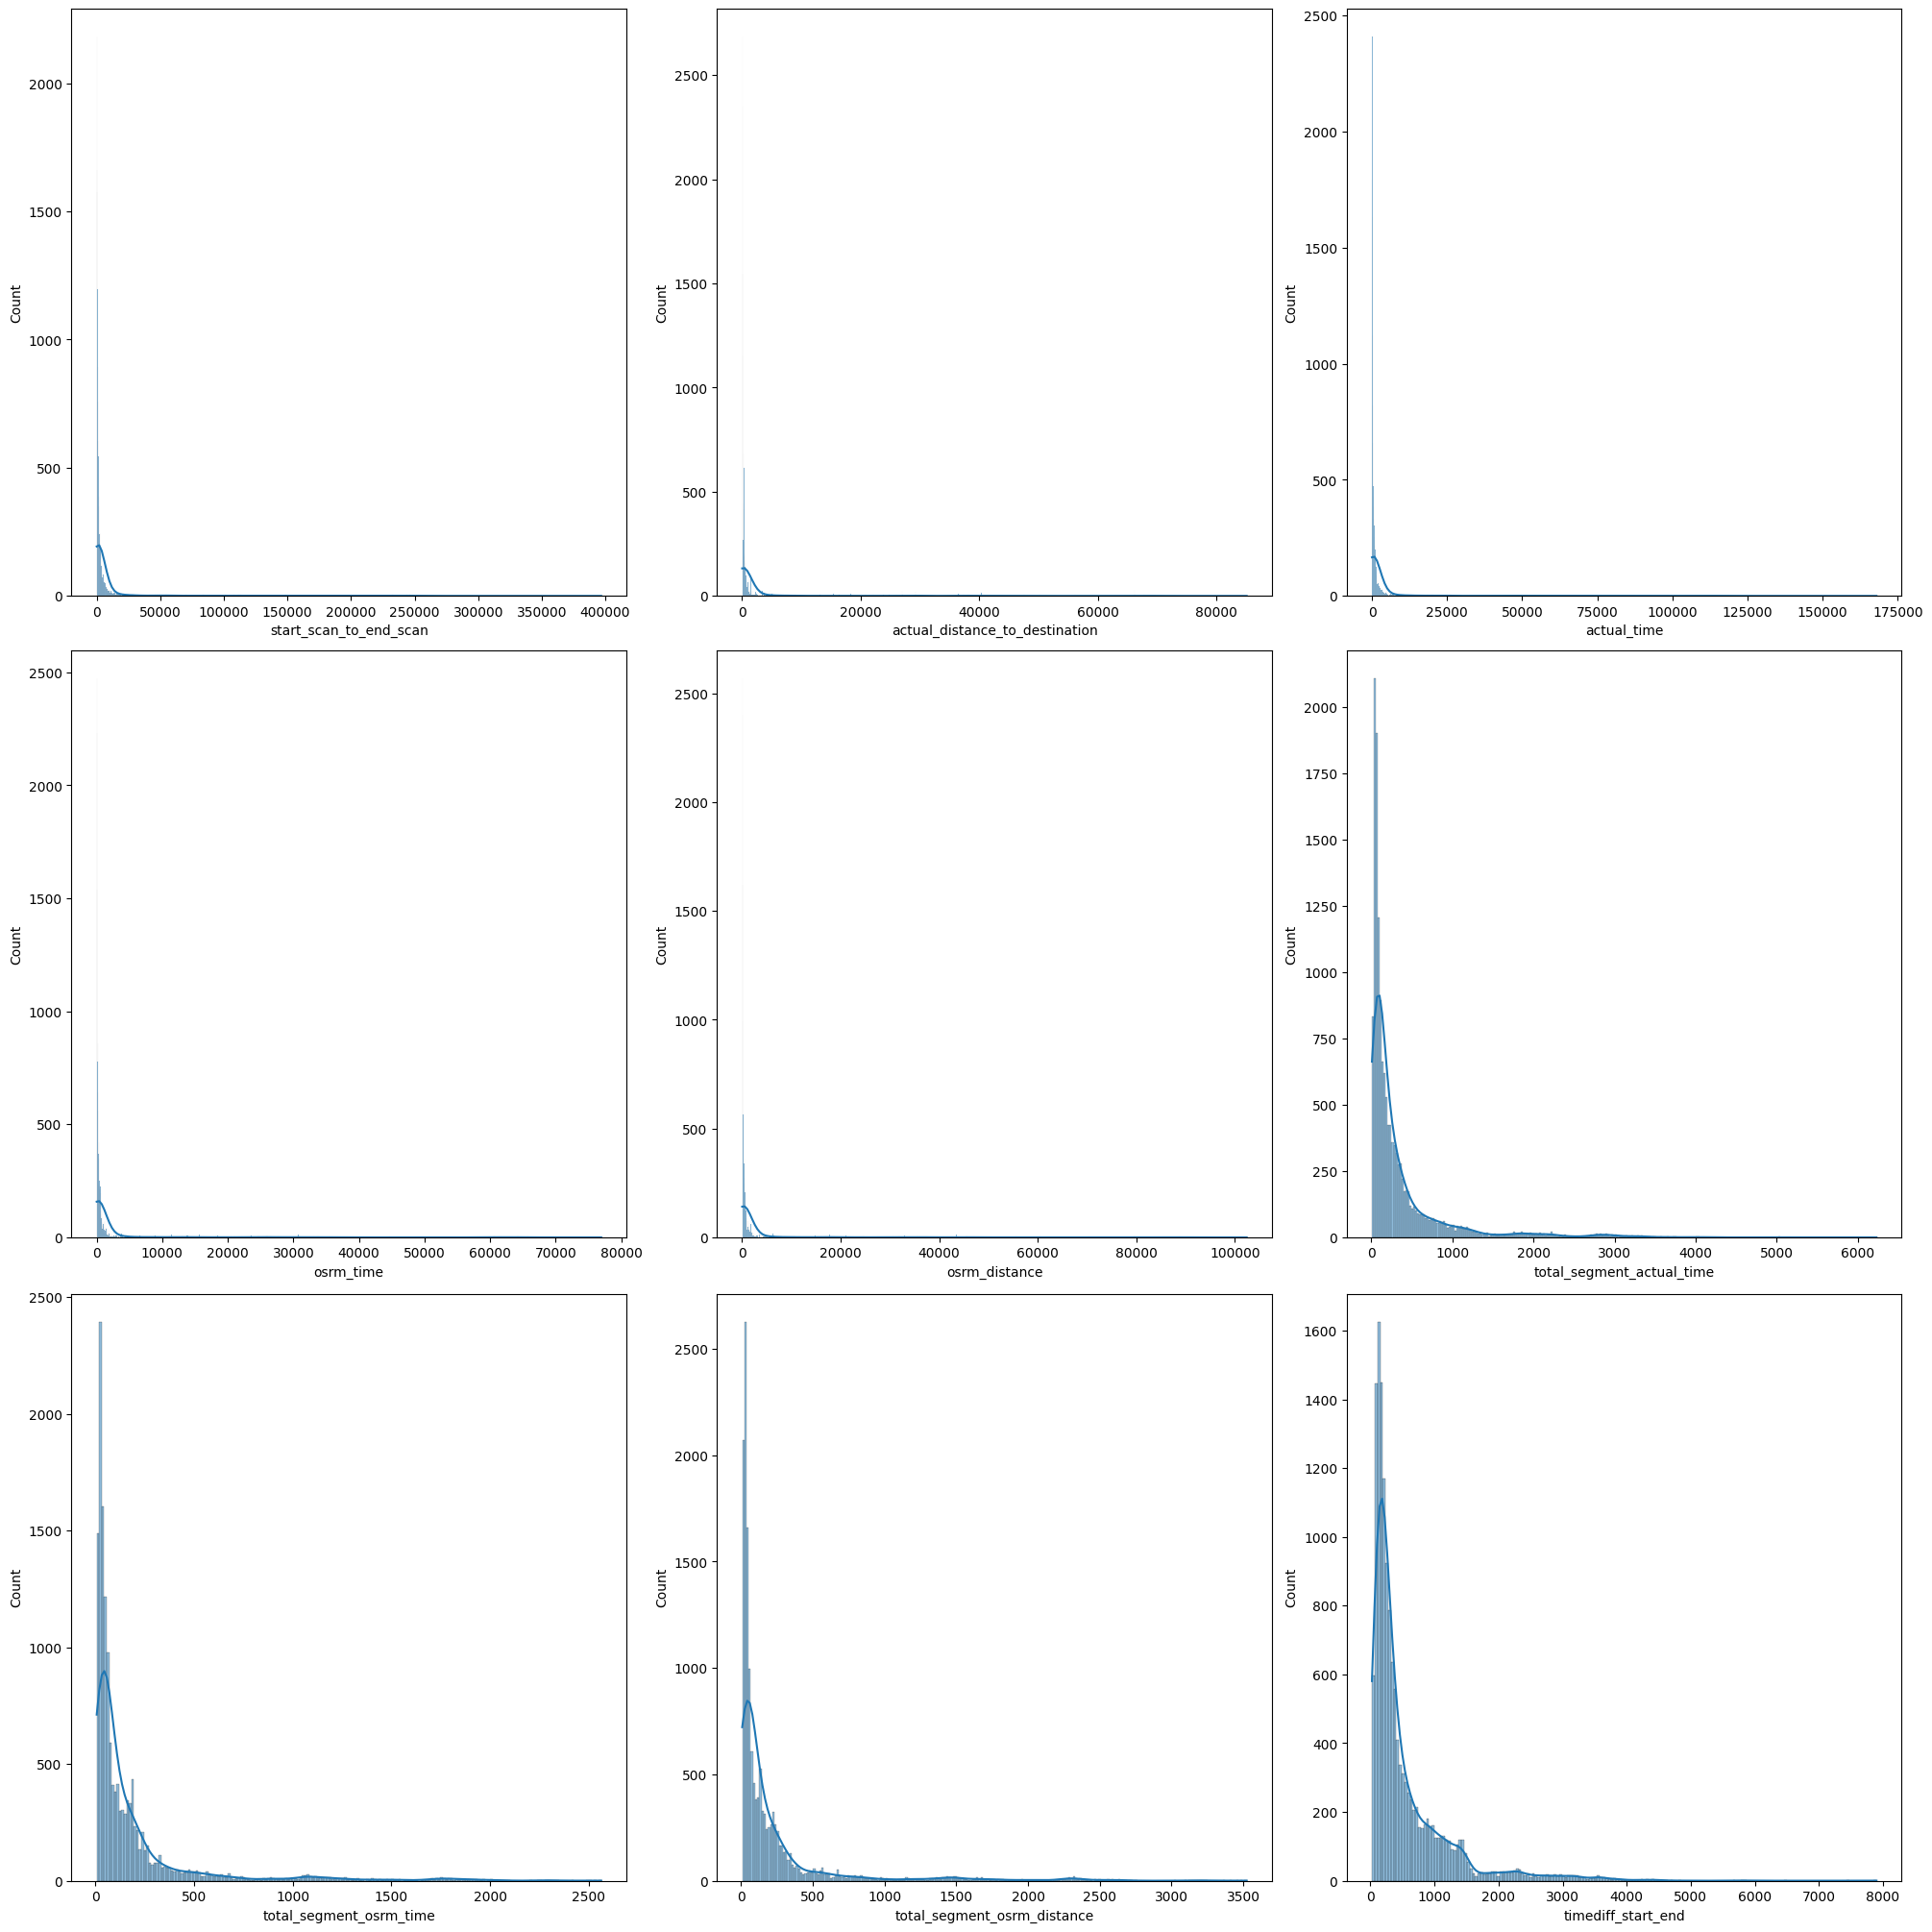

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20,20), layout = 'constrained')
ax = axs.flatten()
for i, col in enumerate(nuemarical_columns):
    sns.histplot(merged_data[col], ax=ax[i],kde=True)


<Axes: >

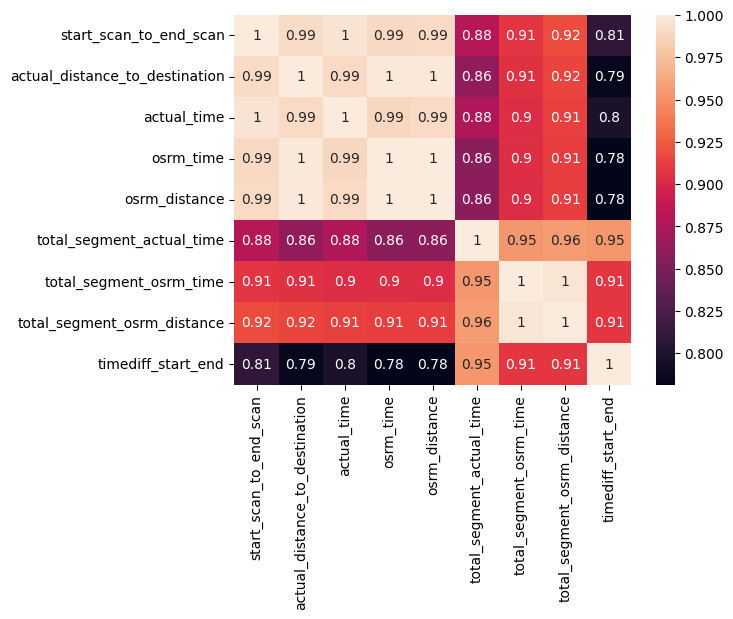

In [ ]:
sns.heatmap(merged_data[nuemarical_columns].corr(),annot=True)

### Analysis of Categorical Variables

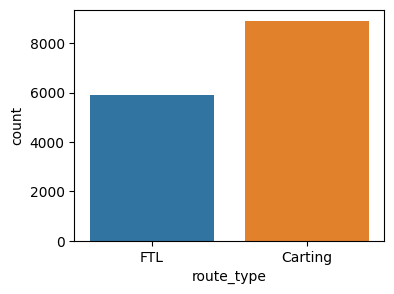

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=merged_data,x='route_type')
plt.show()

- Most of the orders use Carting services

<Axes: xlabel='count', ylabel='destination_state'>

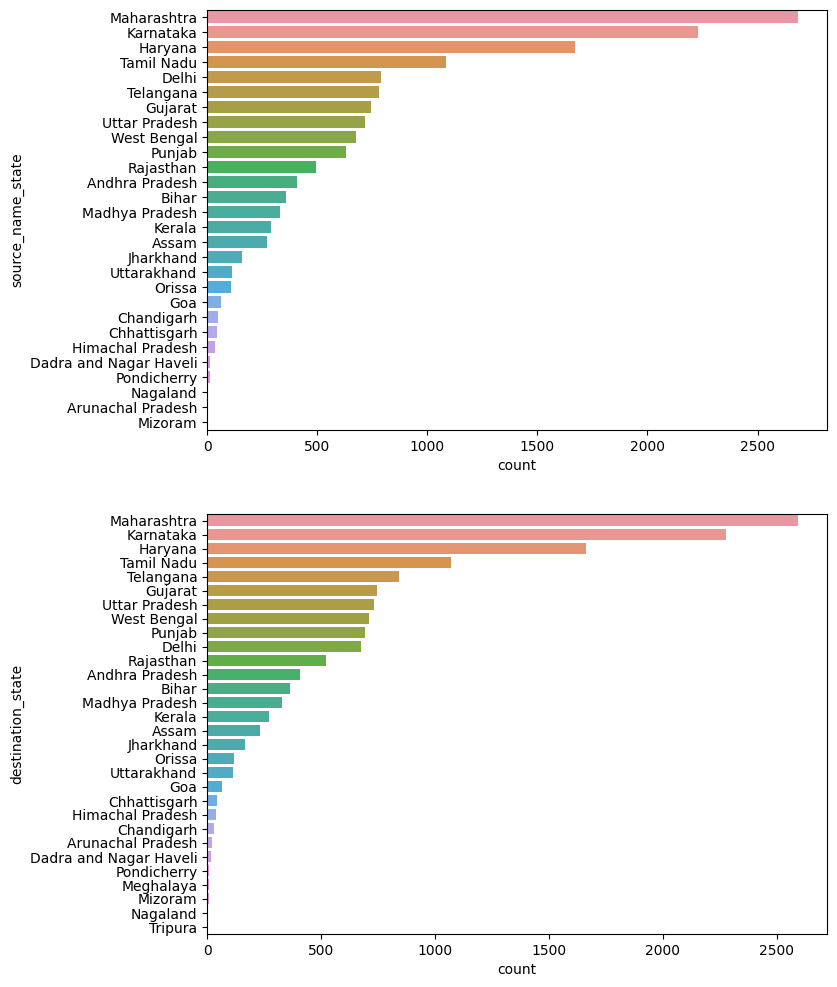

In [ ]:
'''plt.figure(figsize=(8,12))

plt.subplot(2,1,1)
sns.countplot(data=df,y='source_state')

plt.subplot(2,1,2)
sns.countplot(data=df,y='destination_state')

plt.show()
'''
fig,ax = plt.subplots(2,1,figsize=(8,12))
sns.countplot(data=merged_data, y = 'source_name_state', ax = ax[0],
              order=merged_data['source_name_state'].value_counts().index)
sns.countplot(data=merged_data,y = 'destination_state', ax = ax[1],
              order=merged_data['destination_state'].value_counts().index)

- Most number of orders are in Maharastra followed by Karnataka

- Outlier Deyection using Box Plot

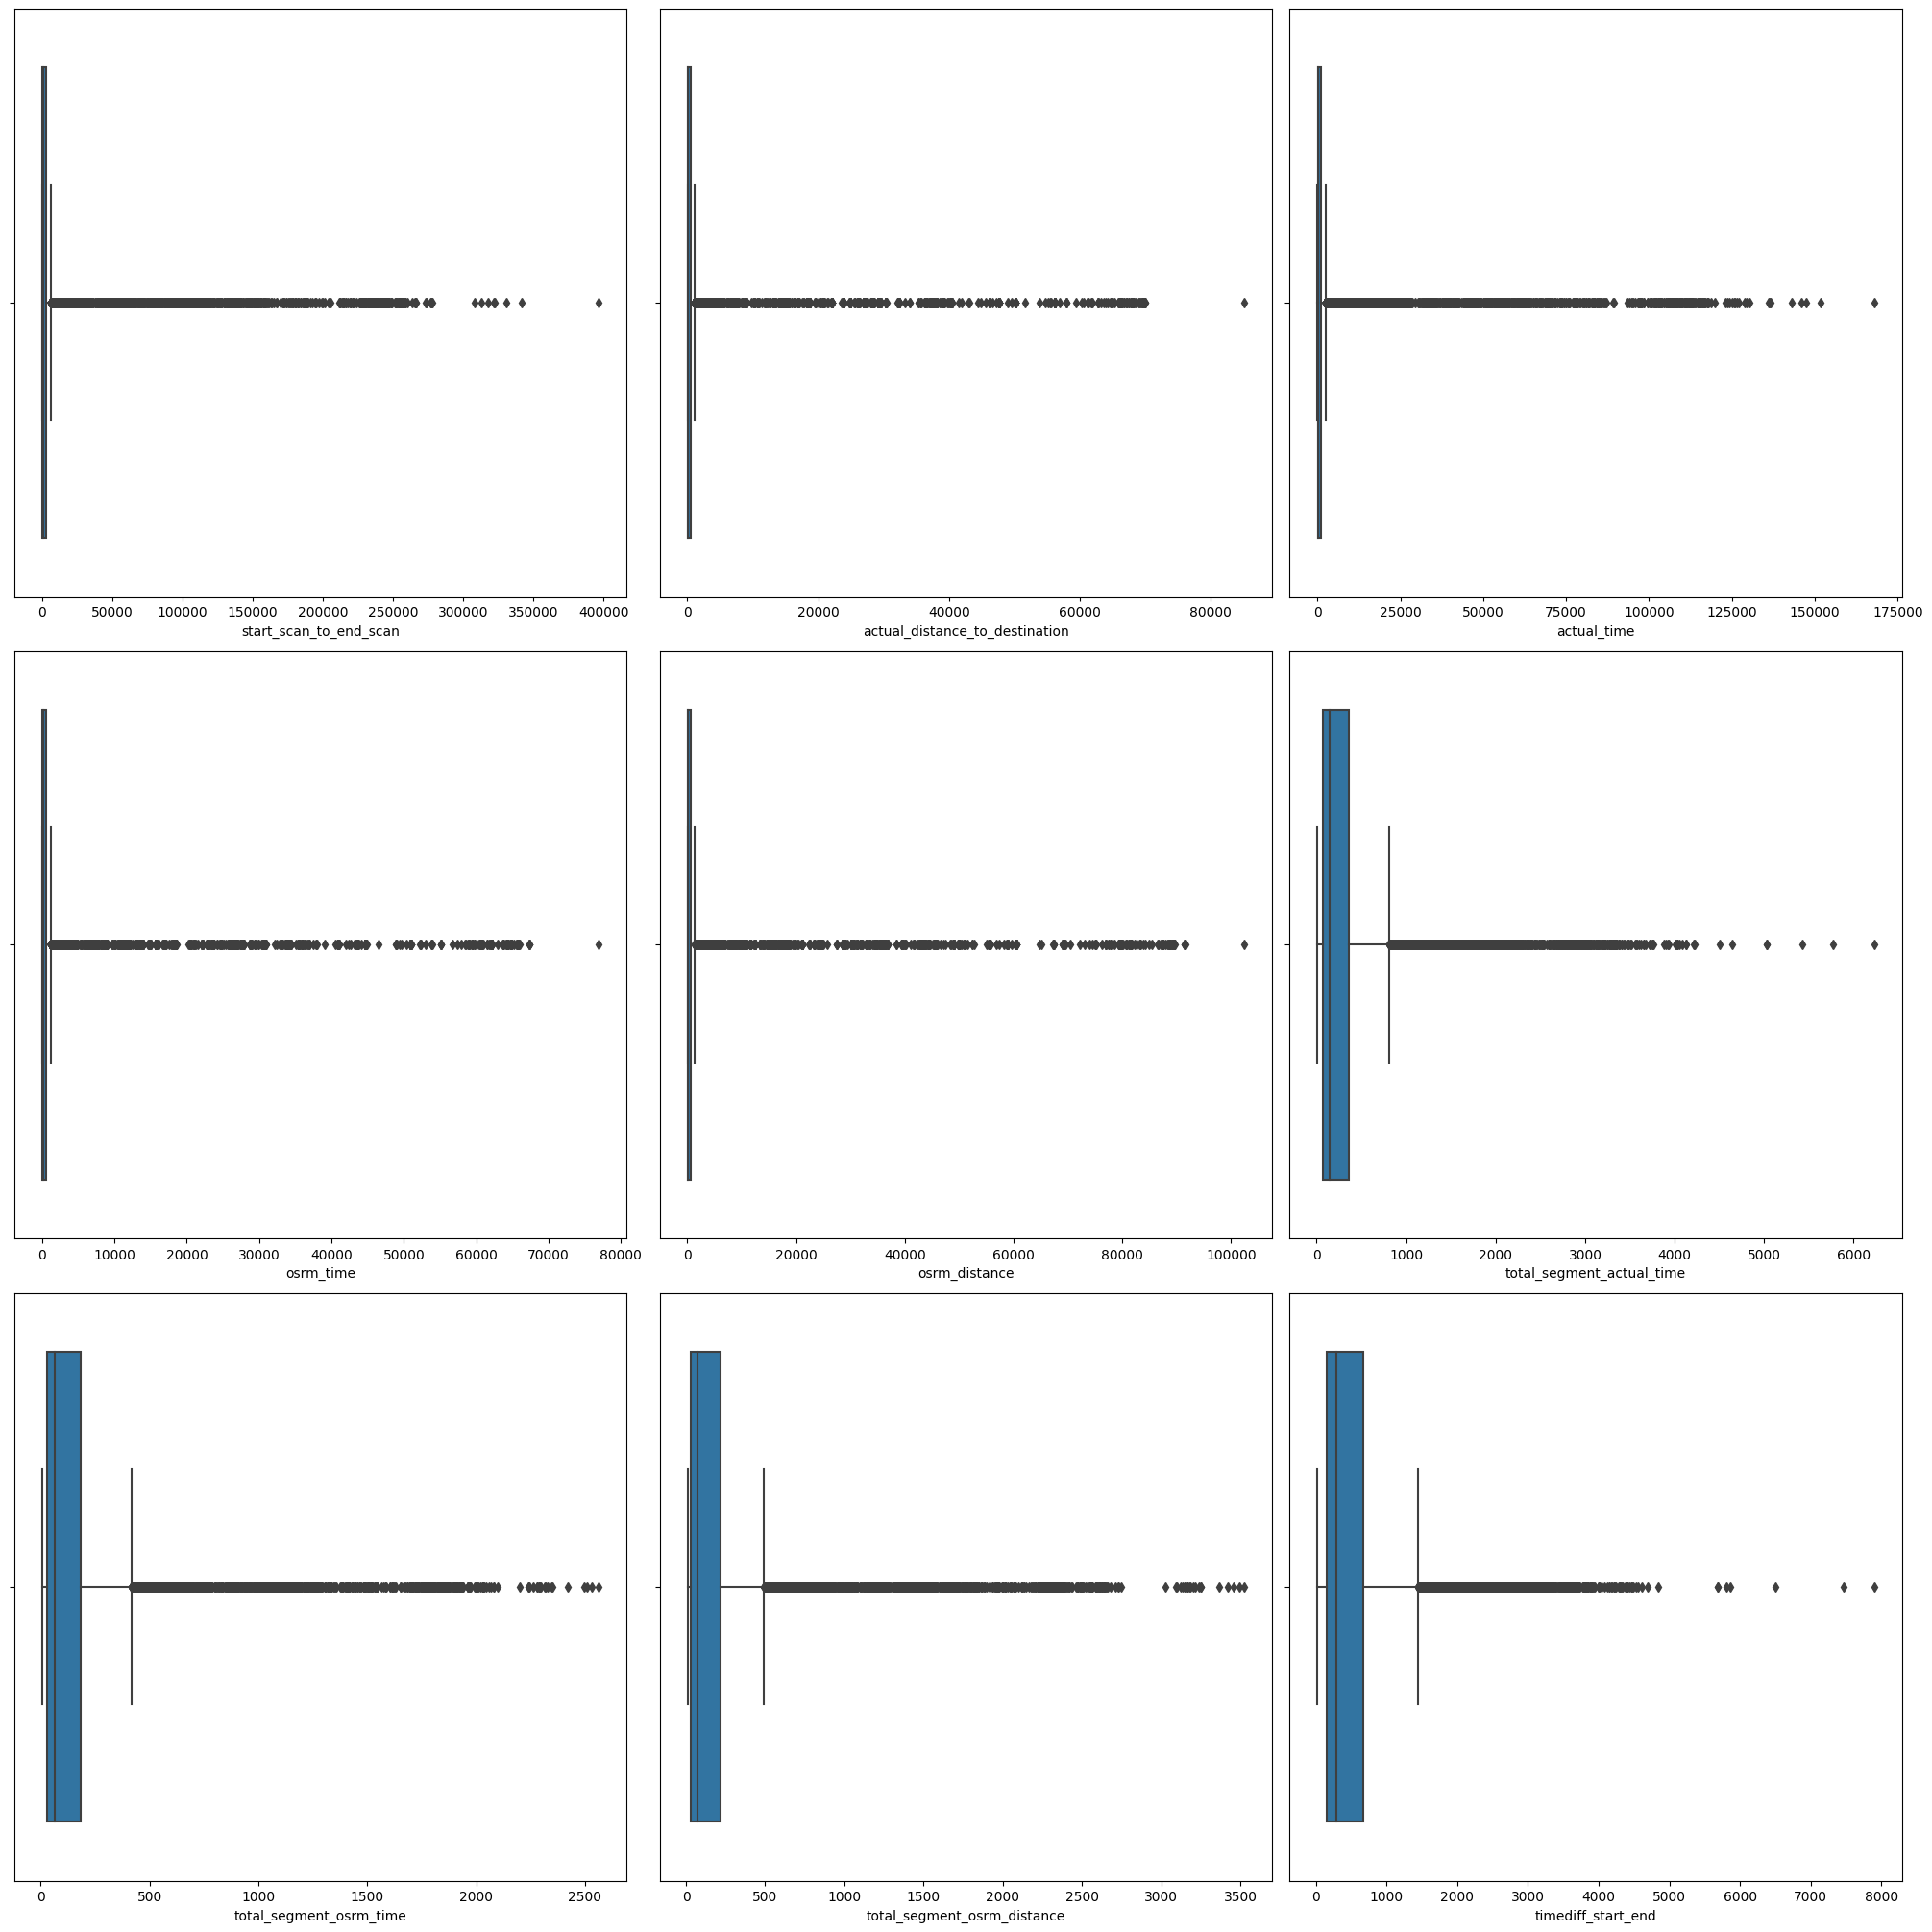

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20,20), layout = 'constrained')
ax = axs.flatten()
for i, col in enumerate(nuemarical_columns):
    sns.boxplot(x=merged_data[col], ax = ax[i])

- Outlier Detection

In [ ]:
# outlier detection
def check_outlier(col):
  q1,q3=np.percentile(col,[25,75])
  iqr=q3-q1
  low=q1 - (1.5 * iqr)
  high=q3 + (1.5 * iqr)
  return low,high

In [ ]:
for col in nuemarical_columns:
  low,high=check_outlier(merged_data[col])
  merged_data[col]=merged_data[col].clip(lower=low,upper=high)

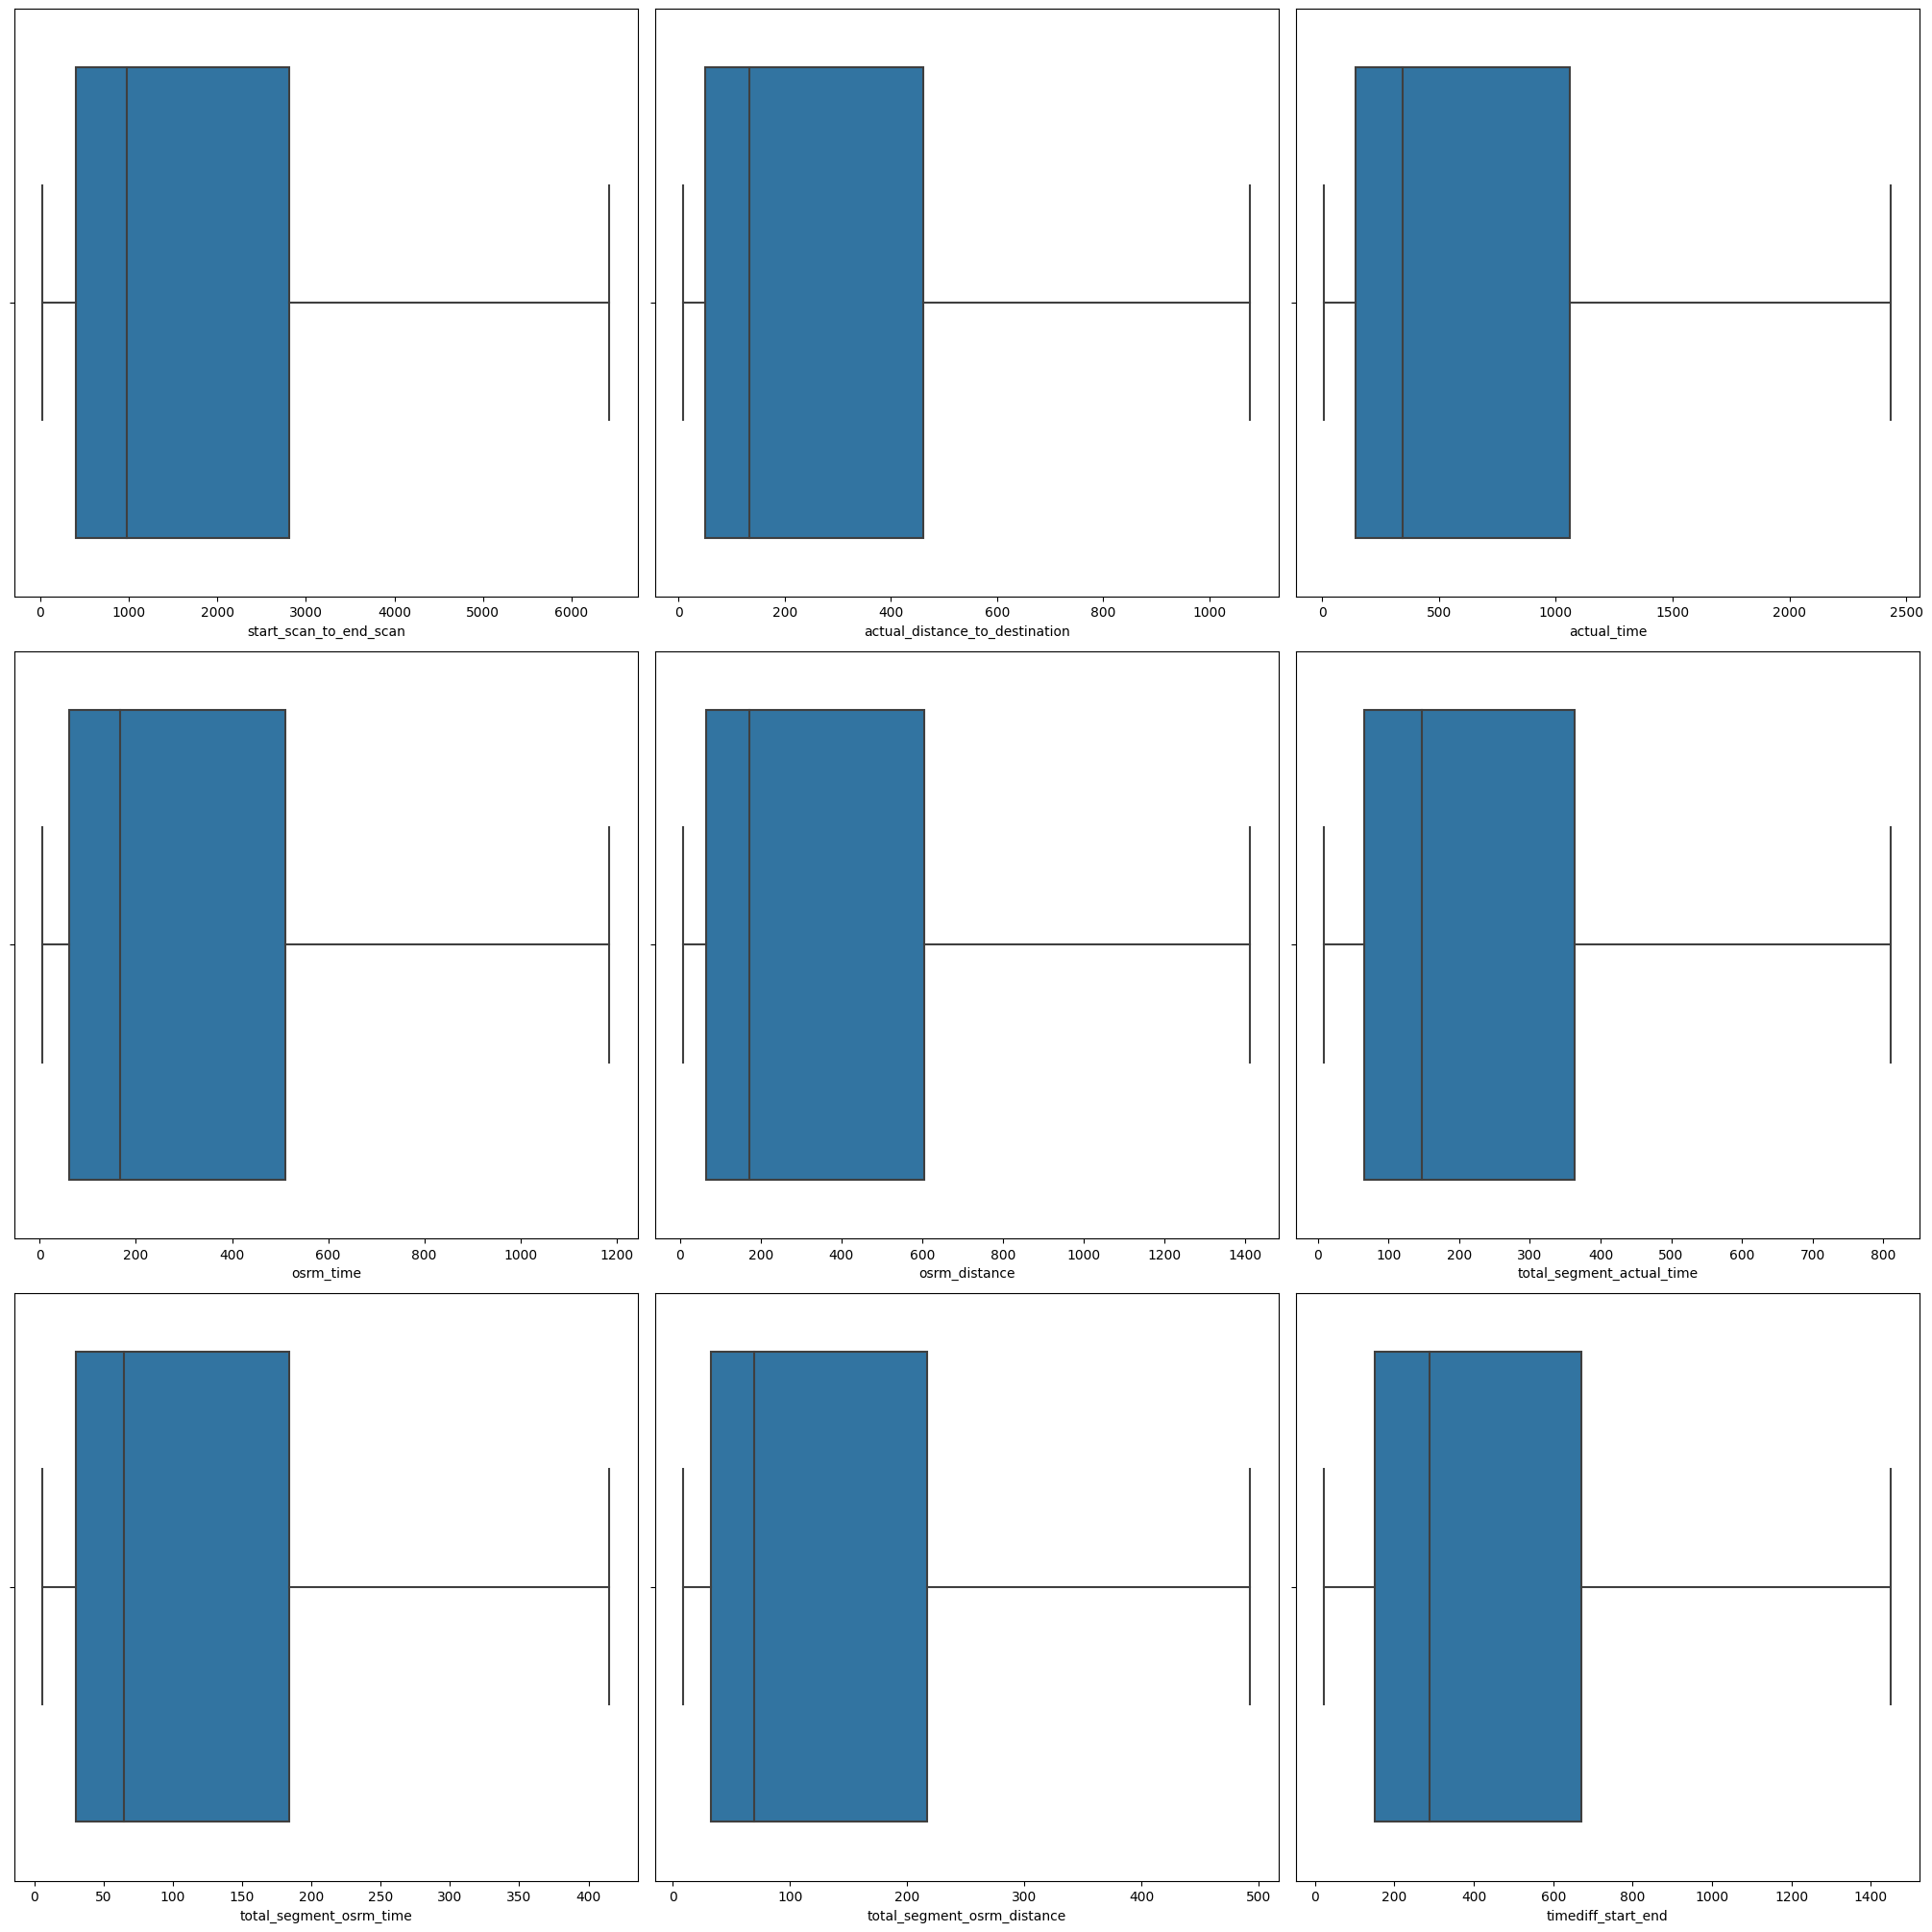

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20,20), layout = 'constrained')
ax = axs.flatten()
for i, col in enumerate(nuemarical_columns):
    sns.boxplot(x=merged_data[col], ax = ax[i])

In [ ]:
merged_data.groupby(['source_name_city','destination_city']).agg(
    count= ('actual_time','count'),
    avg_distance = ("actual_distance_to_destination", "mean"),
    avg_time = ("actual_time", "mean")
).sort_values(by='count',ascending=False).reset_index().head(10)

,source_name_city,destination_city,count,avg_distance,avg_time
0,Bengaluru,Bengaluru,549,89.814254,235.023679
1,Bangalore,Bengaluru,455,77.478596,195.951648
2,Hyderabad,Hyderabad,398,193.097380,428.075377
3,Bhiwandi,Mumbai,332,54.694023,163.153614
4,Bengaluru,Bangalore,326,79.897706,243.236196
5,Mumbai,Mumbai,264,29.467949,110.901515
6,Chandigarh,Chandigarh,248,451.595533,1012.927419
7,Gurgaon,Delhi,240,187.964600,464.085417
8,Mumbai,Bhiwandi,207,48.640435,184.545894
9,Chennai,Chennai,201,79.292433,192.054726


In [ ]:
merged_data.groupby(['source_name_state','destination_state']).agg(
    count= ('actual_time','count'),
    avg_distance = ("actual_distance_to_destination", "mean"),
    avg_time = ("actual_time", "mean")
).sort_values(by='count',ascending=False).reset_index().head(10)

,source_name_state,destination_state,count,avg_distance,avg_time
0,Maharashtra,Maharashtra,2406,168.816092,412.049875
1,Karnataka,Karnataka,2015,151.806724,358.285360
2,Tamil Nadu,Tamil Nadu,1016,192.954778,385.321850
3,Haryana,Haryana,867,293.928029,659.598039
4,Telangana,Telangana,655,217.396165,468.625954
5,Gujarat,Gujarat,624,231.099240,439.296474
6,West Bengal,West Bengal,610,210.857375,613.948361
7,Uttar Pradesh,Uttar Pradesh,544,254.640475,730.346507
8,Punjab,Punjab,491,389.946581,807.711813
9,Rajasthan,Rajasthan,422,425.597655,905.318720


## Hypothesis Tests

### 1) diff(od_start_time-od.end_time)= 'timediff_start_end' and 'start_scan_to_end_scan'

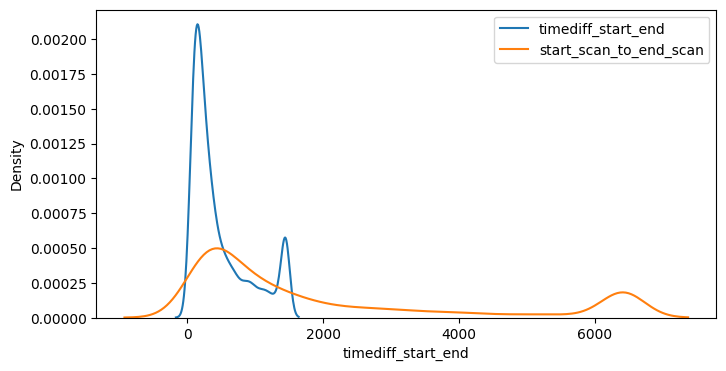

In [ ]:
# Visual check
plt.figure(figsize=(8,4))
sns.kdeplot(merged_data['timediff_start_end'], label ='timediff_start_end')
sns.kdeplot(merged_data['start_scan_to_end_scan'], label ='start_scan_to_end_scan')
plt.legend()
plt.show()

Hypothesis test- We will perform a 2 sample t test -

𝝻o , 𝝻a : means of 'start_scan_to_end_scan' and timediff_start_end

Ho : 𝝻o = 𝝻a no difference betweeen means of both data

Ha : 𝝻o != 𝝻a there is a statistically significant difference

In [ ]:
t_stat,p_val=ttest_ind(merged_data['timediff_start_end'],merged_data['start_scan_to_end_scan'])
print(p_val)
if p_val < 0.05:
  print("reject HO")
else:
  print("fail to reject HO")

0.0
reject HO


- Reject null hypothesis. The difference between start_scan_to_end_scan and timediff_start_end (The difference between od start and od end time)  is statistically significant.

### 2) actual_time_aggregated value and osrm_time_aggregated value

- Visual Check

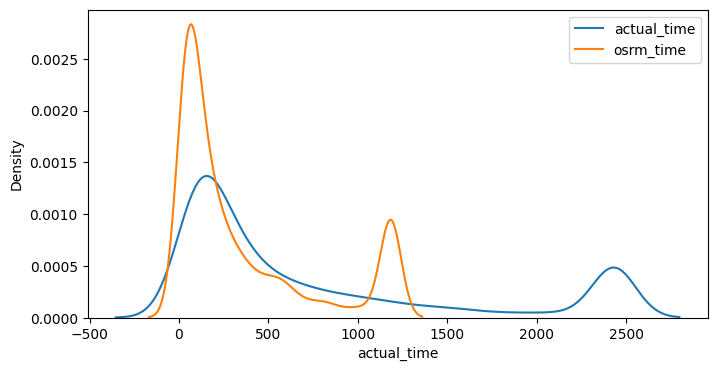

In [ ]:
# Visual check
plt.figure(figsize=(8,4))
sns.kdeplot(merged_data['actual_time'], label ='actual_time')
sns.kdeplot(merged_data['osrm_time'], label ='osrm_time')
plt.legend()
plt.show()

- Hypothesis test- We will perform a 2 sample t test -

𝝻o , 𝝻a : means of 'actual_time' and 'osrm_time'

Ho : 𝝻o = 𝝻a no difference betweeen means of both data

Ha : 𝝻o != 𝝻a there is a statistically significant difference

In [ ]:
# Hypothesis test
t_stat,p_val=ttest_ind(merged_data['actual_time'],merged_data['osrm_time'])
print(p_val)
if p_val < 0.05:
  print("reject HO")
else:
  print("fail to reject HO")

0.0
reject HO


- We have enough evidence to reject the null hypothesis. That means there is statitically significant difference between actual time aggregated value and osrm time aggregated value.

### 3) actual_time_aggregated value and segment_actual_time_aggregated value

- Visual check -

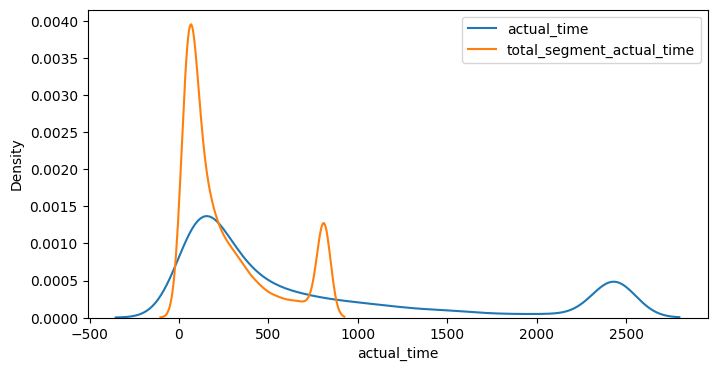

In [ ]:
# Visual check
plt.figure(figsize=(8,4))
sns.kdeplot(merged_data['actual_time'], label ='actual_time')
sns.kdeplot(merged_data['total_segment_actual_time'], label ='total_segment_actual_time')
plt.legend()
plt.show()

- Hypothesis test- We will perform a 2 sample t test -

𝝻o , 𝝻a : means of 'actual_time' and 'segment_actual_time'

Ho : 𝝻o = 𝝻a no difference betweeen means of both data

Ha : 𝝻o != 𝝻a there is a statistically significant difference

In [ ]:
# Hypothesis test
t_stat,p_val=ttest_ind(merged_data['actual_time'],merged_data['total_segment_actual_time'])
print(p_val)
if p_val < 0.05:
  print("reject HO")
else:
  print("fail to reject HO")

0.0
reject HO


- reject null hypothesis. This implies that there is  difference between total_segment_actual_time and actual_time.

### 4) osrm_time_aggregated value and segment_osrm_time_aggregated value

- Visual check -

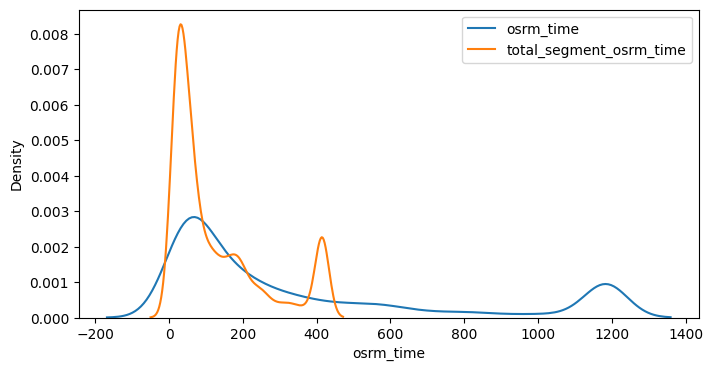

In [ ]:
# Visual check
plt.figure(figsize=(8,4))
sns.kdeplot(merged_data['osrm_time'], label ='osrm_time')
sns.kdeplot(merged_data['total_segment_osrm_time'], label ='total_segment_osrm_time')
plt.legend()
plt.show()

- Hypothesis test- We will perform a 2 sample t test -

𝝻o , 𝝻a : means of 'osrm_time' and 'segment_osrm_time'

Ho : 𝝻o = 𝝻a no difference betweeen means of both data

Ha : 𝝻o != 𝝻a there is a statistically significant difference

In [ ]:
# Hypothesis test
t_stat,p_val=ttest_ind(merged_data['osrm_time'],merged_data['total_segment_osrm_time'])
print(p_val)
if p_val < 0.05:
  print("reject HO")
else:
  print("fail to reject HO")

0.0
reject HO


- Reject null hypothesis. The difference between osrm_time and total_segment_osrm_time is statistically significant.

### 5) osrm_distance_aggregated value and segment_osrm_distance_aggregated value

- Visual check -

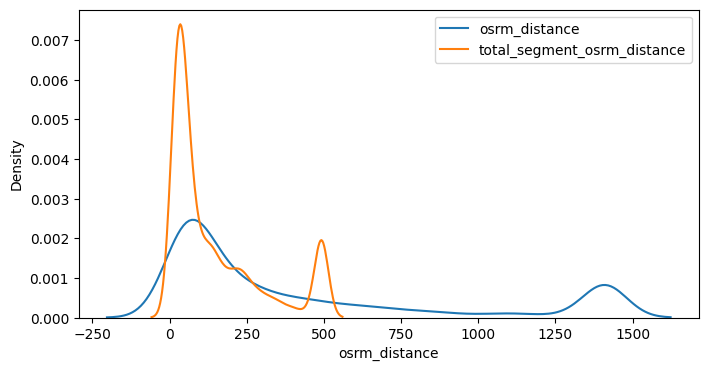

In [ ]:
# Visual check
plt.figure(figsize=(8,4))
sns.kdeplot(merged_data['osrm_distance'], label ='osrm_distance')
sns.kdeplot(merged_data['total_segment_osrm_distance'], label ='total_segment_osrm_distance')
plt.legend()
plt.show()

- Hypothesis test- We will perform a 2 sample t test -

𝝻o , 𝝻a : means of 'osrm_distance' and 'segment_osrm_distance'

Ho : 𝝻o = 𝝻a no difference betweeen means of both data

Ha : 𝝻o != 𝝻a there is a statistically significant difference

In [ ]:
# Hypothesis test
t_stat,p_val=ttest_ind(merged_data['osrm_distance'],merged_data['total_segment_osrm_distance'])
print(p_val)
if p_val < 0.05:
  print("reject HO")
else:
  print("fail to reject HO")

0.0
reject HO


- Reject null hypothesis. The difference between osrm_distance and  total_segment_osrm_distance is statistically significant.

### Categorical variable encoding -

In [ ]:
# Since there are only 2 values for the categorical variable of route_type we use label encoder

from sklearn.preprocessing import LabelEncoder

print('Before Label Encoding')
print(merged_data['route_type'].value_counts())

label_encoder=LabelEncoder()
merged_data['route_type']=label_encoder.fit_transform(merged_data['route_type'])

print('After Label Encoding')
print(merged_data['route_type'].value_counts())

Before Label Encoding
Carting    8906
FTL        5881
Name: route_type, dtype: int64
After Label Encoding
0    8906
1    5881
Name: route_type, dtype: int64


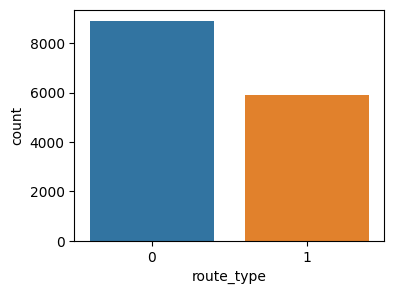

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(data=merged_data,x='route_type')
plt.show()

- Other categorical features like source city, destinamtion city, source name, destination name have large number of values so one hot encoding is practical.

### Standardizing columns

In [ ]:
# nuemarical columns
print(nuemarical_columns)

['start_scan_to_end_scan', 'actual_distance_to_destination', 'actual_time', 'osrm_time', 'osrm_distance', 'total_segment_actual_time', 'total_segment_osrm_time', 'total_segment_osrm_distance', 'timediff_start_end']


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
std_data = scaler.fit_transform(merged_data[nuemarical_columns])
std_data = pd.DataFrame(std_data, columns = nuemarical_columns)
std_data . head(3)

,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,total_segment_actual_time,total_segment_osrm_time,total_segment_osrm_distance,timediff_start_end
0,2.053505,2.026268,2.048228,2.095603,2.062086,2.141970,2.259726,2.254747,2.254825
1,-0.499871,-0.225054,-0.420272,-0.360525,-0.306451,-0.462704,-0.473161,-0.401315,-0.672091
2,2.053505,2.026268,2.048228,2.095603,2.062086,2.141970,2.259726,2.254747,2.254825


## Insights and Recommendations


### EDA based insights

1. There are 144867 rows and 24 columns in raw_data. No duplicate columns found. Very few Nulls were found in source name & destiname name. We have deleted these columns as we have sufficient data
2. we delete the following colums from the raw_data : ['data','is_cutoff','cutoff_factor','cutoff_timestamp','factor','segment_factor'] as no information is provided about them
3. The data types are chaged acording to the nature of variables
4. Most of the colums are highly correlated. Hence some of the columns can be ignored
5. Outliers exist in almost all the nuemarical columns
6. Most number of orders are in Maharastra followed by Karnataka



### Insights from hypothesis testing & distribution analysis
1. The difference between start_scan_to_end_scan and timediff_start_end (The difference between od start and od end time)  is statistically significant.
2. there is statitically significant difference between actual time aggregated value and osrm time aggregated value.
3. there is  difference between total_segment_actual_time and actual_time.
4. The difference between osrm_time and total_segment_osrm_time is statistically significant
5. The difference between osrm_distance and  total_segment_osrm_distance is statistically significant.

### Generic recommendations
1. Karnataka, Maharsahtra and Haryana are the three top states in terms of logistics movements and hence, more resources should be deployed to these locations
2. In the forecasting model, we can eliminate similar columns as observed in hypothesis testing and correlation check
3. Better route planning should be done as we can see actual time taken is roughly three times the osrm time
Objective should be to bring the actual distance nearer to osrm distance, by either changing routes or the mode of transaportation
